In [1]:
import os
import sys

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

src_path = os.path.dirname(os.getcwd())
sys.path.append(src_path)

from RNN.data_processing import window_dataset

# Time series forecast with RNN: Exammples

The present notebook presents examples of predicting the time series used in the previous chapters with RNN models. As seen in the model description RNN can take as inputs multivariate sequences and forecast either univariate or multivariate outputs, therefore in each case we will use all covariates and information knwon in the dataset, in oposition to the univariate approach seen in previous cases, since the model supports the inclusion of them.


## Case 1: Campylobacter Infections

Time series with the number of cases of campylobacter infections in the north of the province Quebec (Canada) in four weekintervals from January 1990 to the end of October 2000. I has 13 observations per year and 140 observations in total. Campylobacterosisis an acute bacterial infectious disease attacking the digestive system.

#### Source
Ferland, R., Latour, A. and Oraichi, D. (2006) Integer-valued GARCH process. Journal of Time Series Analysis 27(6), 923–942, http://dx.doi.org/10.1111/j.1467-9892.2006.00496.x.

### Data reading

In [2]:
raw_data = pd.read_csv(os.path.join(src_path, "data", "campylobacter_data.csv"))
raw_data.head()

,Unnamed: 0,x
0,1,2
1,2,3
2,3,4
3,4,1
4,5,6


In [3]:
data = raw_data.drop(columns=["Unnamed: 0"])
data.shape

(140, 1)

Since we know both the time period of the data and the periodicity we can add to the model the information corresponding to year and period to be used as covariates in the model and allow it to take advantageof all available information.

In [4]:
years = range(1990, 2001)
periods = range(1,14)
pairs = [[year, period] for year in years for period in periods][:-3]

data = pd.concat([data, pd.DataFrame(pairs)], axis = 1)
data.columns = ["cases", "year", "period"]
data.head()

,cases,year,period
0,2,1990,1
1,3,1990,2
2,4,1990,3
3,1,1990,4
4,6,1990,5


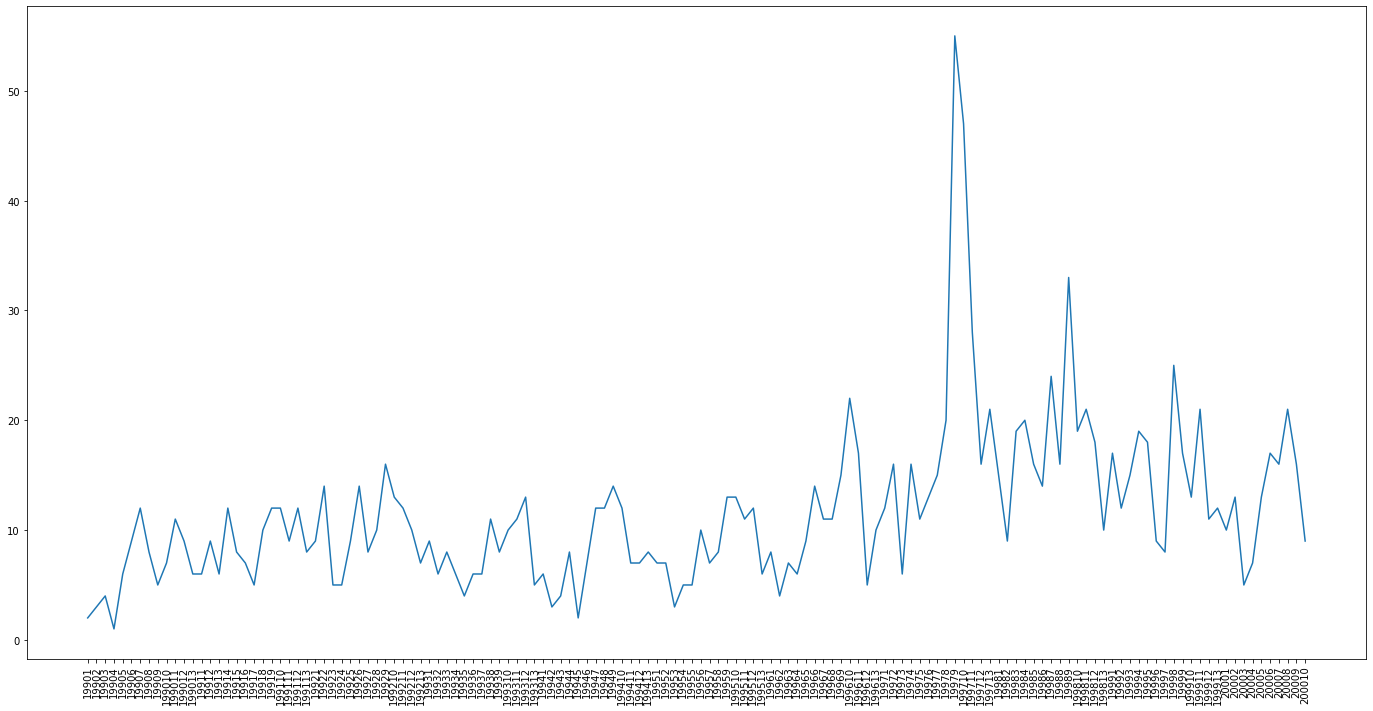

In [5]:
x_labels = (data.year.astype('str') + data.period.astype('str')).values
plt.figure(figsize=(24,12))
plt.plot(data.cases.values)
plt.xticks(np.arange(140), x_labels, rotation=90)
plt.show()

### Preprocessing

We start by scaling the data using a minmax transformation to take it to the interval (0,1) which improves the model's convergence. 

In [6]:
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(data)

We also save an scaler object for the response variable to be used to apply and inverse transformation to the predictions to take them to the original scale.

In [7]:
response_scaler = MinMaxScaler()
response_scaler.fit(data['cases'].values.reshape(-1,1))

MinMaxScaler()

As presented, applying the inverse transforation to the scaled response is equal to the original data

In [14]:
response_scaler.inverse_transform(scaled_data[:,0].reshape(-1,1)).reshape(-1)

array([ 2.,  3.,  4.,  1.,  6.,  9., 12.,  8.,  5.,  7., 11.,  9.,  6.,
        6.,  9.,  6., 12.,  8.,  7.,  5., 10., 12., 12.,  9., 12.,  8.,
        9., 14.,  5.,  5.,  9., 14.,  8., 10., 16., 13., 12., 10.,  7.,
        9.,  6.,  8.,  6.,  4.,  6.,  6., 11.,  8., 10., 11., 13.,  5.,
        6.,  3.,  4.,  8.,  2.,  7., 12., 12., 14., 12.,  7.,  7.,  8.,
        7.,  7.,  3.,  5.,  5., 10.,  7.,  8., 13., 13., 11., 12.,  6.,
        8.,  4.,  7.,  6.,  9., 14., 11., 11., 15., 22., 17.,  5., 10.,
       12., 16.,  6., 16., 11., 13., 15., 20., 55., 47., 28., 16., 21.,
       15.,  9., 19., 20., 16., 14., 24., 16., 33., 19., 21., 18., 10.,
       17., 12., 15., 19., 18.,  9.,  8., 25., 17., 13., 21., 11., 12.,
       10., 13.,  5.,  7., 13., 17., 16., 21., 16.,  9.])

In [15]:
data['cases'].values

array([ 2,  3,  4,  1,  6,  9, 12,  8,  5,  7, 11,  9,  6,  6,  9,  6, 12,
        8,  7,  5, 10, 12, 12,  9, 12,  8,  9, 14,  5,  5,  9, 14,  8, 10,
       16, 13, 12, 10,  7,  9,  6,  8,  6,  4,  6,  6, 11,  8, 10, 11, 13,
        5,  6,  3,  4,  8,  2,  7, 12, 12, 14, 12,  7,  7,  8,  7,  7,  3,
        5,  5, 10,  7,  8, 13, 13, 11, 12,  6,  8,  4,  7,  6,  9, 14, 11,
       11, 15, 22, 17,  5, 10, 12, 16,  6, 16, 11, 13, 15, 20, 55, 47, 28,
       16, 21, 15,  9, 19, 20, 16, 14, 24, 16, 33, 19, 21, 18, 10, 17, 12,
       15, 19, 18,  9,  8, 25, 17, 13, 21, 11, 12, 10, 13,  5,  7, 13, 17,
       16, 21, 16,  9], dtype=int64)

### Data Windows generation

To train the model the dataset need to be organized in windows relating the input sequence to the expected output. In this case 1 year ofinformation will be used to forecast a week, therefore wee need windows with an input's lenght of 13 and 3 covariates and an output's lenght of 1 and univariate.

In [16]:
ds = window_dataset(
    data=scaled_data,
    sequence_lenght=13,
    output_lenght=1,
    batch_size=1,
    shift=1,
    output_index=0,
    shuffle=False    
)
print('Example sample')
for (x,y) in ds:
    print('input shape:', x.numpy().shape)
    print('output shape:', y.numpy().shape)
    print(x)
    print(y)
    break

Example sample
input shape: (1, 13, 3)
output shape: (1, 1)
tf.Tensor(
[[[0.01851852 0.         0.        ]
  [0.03703704 0.         0.08333333]
  [0.05555556 0.         0.16666667]
  [0.         0.         0.25      ]
  [0.09259259 0.         0.33333333]
  [0.14814815 0.         0.41666667]
  [0.2037037  0.         0.5       ]
  [0.12962963 0.         0.58333333]
  [0.07407407 0.         0.66666667]
  [0.11111111 0.         0.75      ]
  [0.18518519 0.         0.83333333]
  [0.14814815 0.         0.91666667]
  [0.09259259 0.         1.        ]]], shape=(1, 13, 3), dtype=float64)
tf.Tensor([[0.09259259]], shape=(1, 1), dtype=float64)


### Model trainning

To train the model we will initially determine an amount of epochs that garantees best fitting but without overfit, which will be achieved by dividing the dataset into training and validation sets and evaluating the validation loss.

Then, we will use all data to fit the model and evaluate the quality of the value predictedby the model.

In [17]:
trian_size = int(0.85*scaled_data.shape[0])
train_data, val_data = scaled_data[:trian_size], scaled_data[trian_size:] 

train_ds = window_dataset(
    data=train_data,
    sequence_lenght=13,
    output_lenght=1,
    batch_size=64,
    shift=1,
    output_index=0,
    shuffle=True    
)

val_ds = window_dataset(
    data=val_data,
    sequence_lenght=13,
    output_lenght=1,
    batch_size=64,
    shift=1,
    output_index=0,
    shuffle=False    
)


In [25]:
#### RNN model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(13,3)),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse']
)

history = lstm_model.fit(train_ds, validation_data=val_ds,epochs=1000, verbose=0)

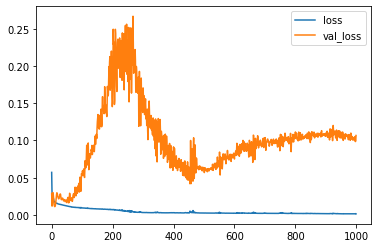

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
np.argmin(history.history['val_loss'][100:])
# epochs to be used when fitting

354

In [28]:
full_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=13,
    output_lenght=1,
    batch_size=64,
    shift=1,
    output_index=0,
    shuffle=True    
)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(13,3)),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse']
)

history = lstm_model.fit(full_ds,epochs=350, verbose=0)

### Prediction and evaluation

In [29]:
predict_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=13,
    output_lenght=1,
    batch_size=127,
    shift=1,
    output_index=0,
    shuffle=False    
)
preds = lstm_model.predict(predict_ds)

In [30]:
orig_preds = response_scaler.inverse_transform(preds)
orig_preds = orig_preds.reshape(-1)

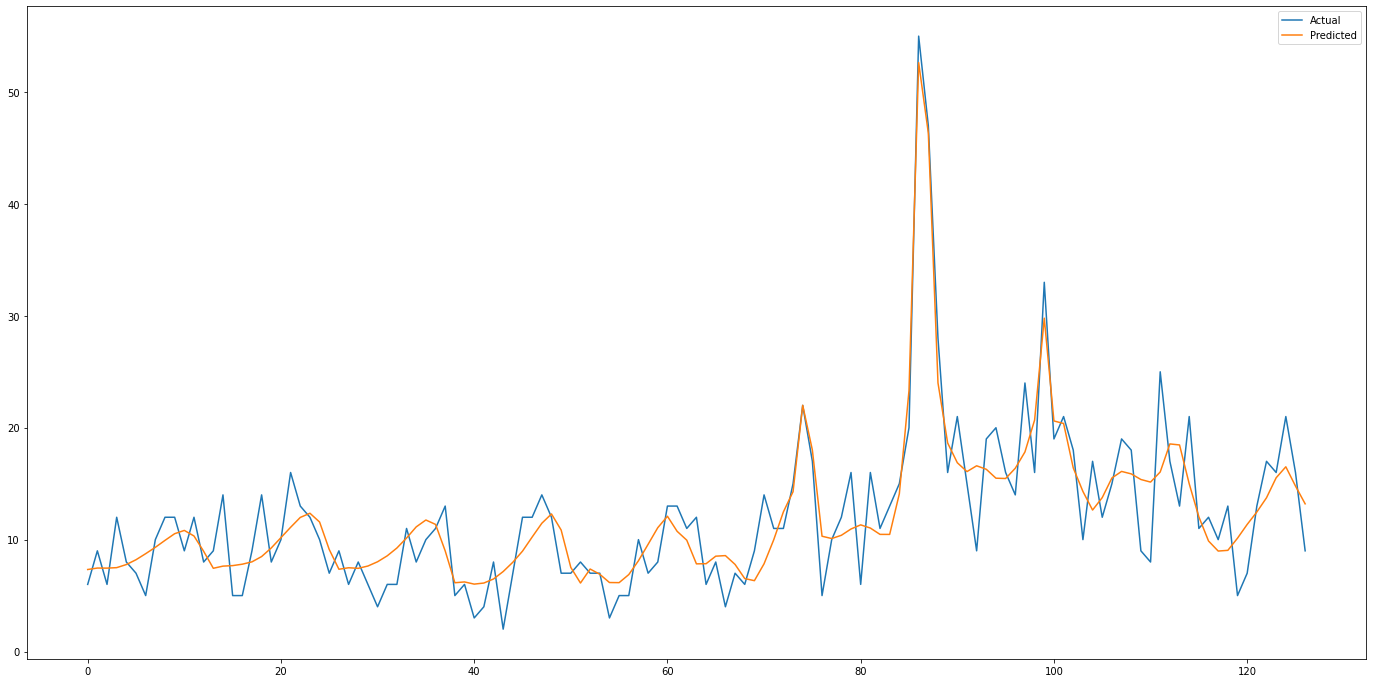

In [31]:
plt.figure(figsize=(24,12))
plt.plot(data['cases'].values[13:])
plt.plot(orig_preds)
plt.legend(["Actual", "Predicted"])
plt.show()

In [32]:
mean_squared_error(data['cases'].values[13:], orig_preds)

9.611126608398298

### Residuals analysis

We check if the residuals seem to be a whitenoise or if the models is failing to include patterns still present in the residuals

In [33]:
residuals = data['cases'].values[13:] - orig_preds

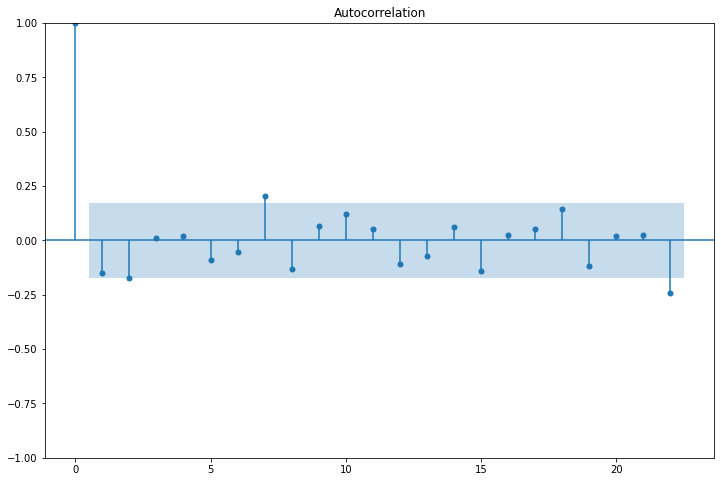

In [34]:
plt.rc("figure", figsize=(12,8))
plot_acf(residuals, bartlett_confint=False)
plt.show()

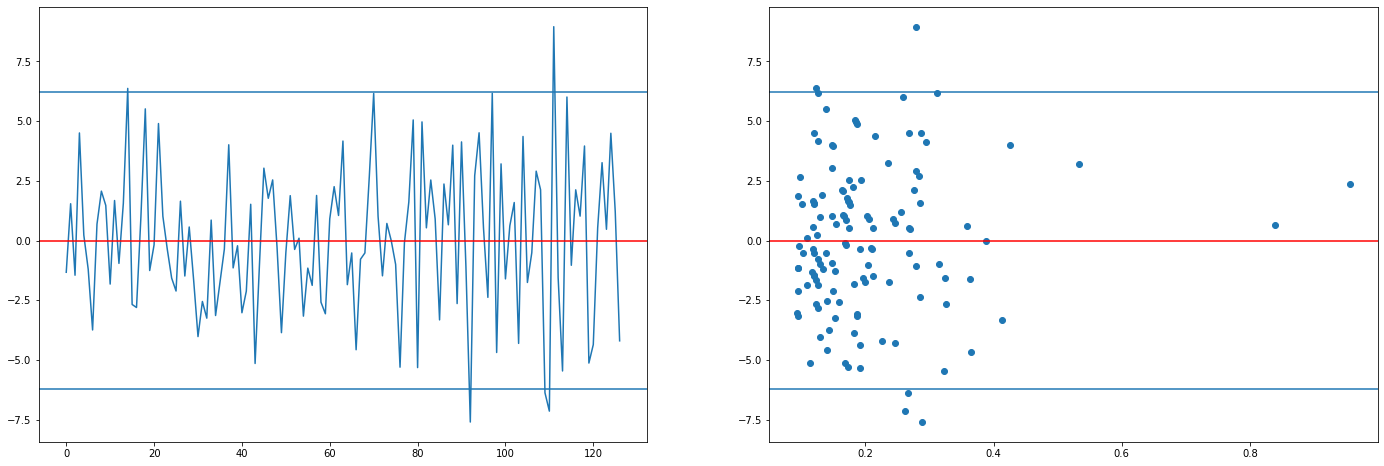

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))

ax1.plot(residuals)
ax1.axhline(0, color='r')
ax1.axhline(2*np.std(residuals))
ax1.axhline(-2*np.std(residuals))

ax2.plot(preds, residuals, 'o')
ax2.axhline(0, color='r')
ax2.axhline(2*np.std(residuals))
ax2.axhline(-2*np.std(residuals))

plt.show()

## Case 2: Road Casualties in Great Britain

Time series giving the monthly totals of car drivers in Great Britan killed or seriously injured between January 1969 toDecember 1984. Compulsry wearing of seat belts was introducedon 31 January 1983.

#### Source

Harvey, A.C. (1989). Forecasting, Structural Time Series Models and the Kalman Filter. Cambridge University Press, pp. 519–523.

Durbin, J. and Koopman, S. J. (2001). Time Series Analysis by State Space Methods. Oxford University Press. http://www.ssfpack.com/dkbook/

### Data reading

In [38]:
raw_data = pd.read_csv(os.path.join(src_path, "data", "road_casualties.csv"))
data = raw_data.drop(columns=["Unnamed: 0"])
print(data.shape)
data.head()

(192, 8)


,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,107,1687,867,269,9059,0.102972,12,0
1,97,1508,825,265,7685,0.102363,6,0
2,102,1507,806,319,9963,0.102062,12,0
3,87,1385,814,407,10955,0.100873,8,0
4,119,1632,991,454,11823,0.101020,10,0


In [39]:
years = range(1969, 1985)
months = range(1,13)
pairs = [[year, month] for year in years for month in months]

data = pd.concat([data, pd.DataFrame(pairs)], axis = 1)
data.columns = [
    "deaths",
    "drivers",
    "front",
    "rear",
    "kms", 
    "petrol_price",
    "van_killed",
    "law",
    "year",
    "month"
]
data.head()

,deaths,drivers,front,rear,kms,petrol_price,van_killed,law,year,month
0,107,1687,867,269,9059,0.102972,12,0,1969,1
1,97,1508,825,265,7685,0.102363,6,0,1969,2
2,102,1507,806,319,9963,0.102062,12,0,1969,3
3,87,1385,814,407,10955,0.100873,8,0,1969,4
4,119,1632,991,454,11823,0.101020,10,0,1969,5


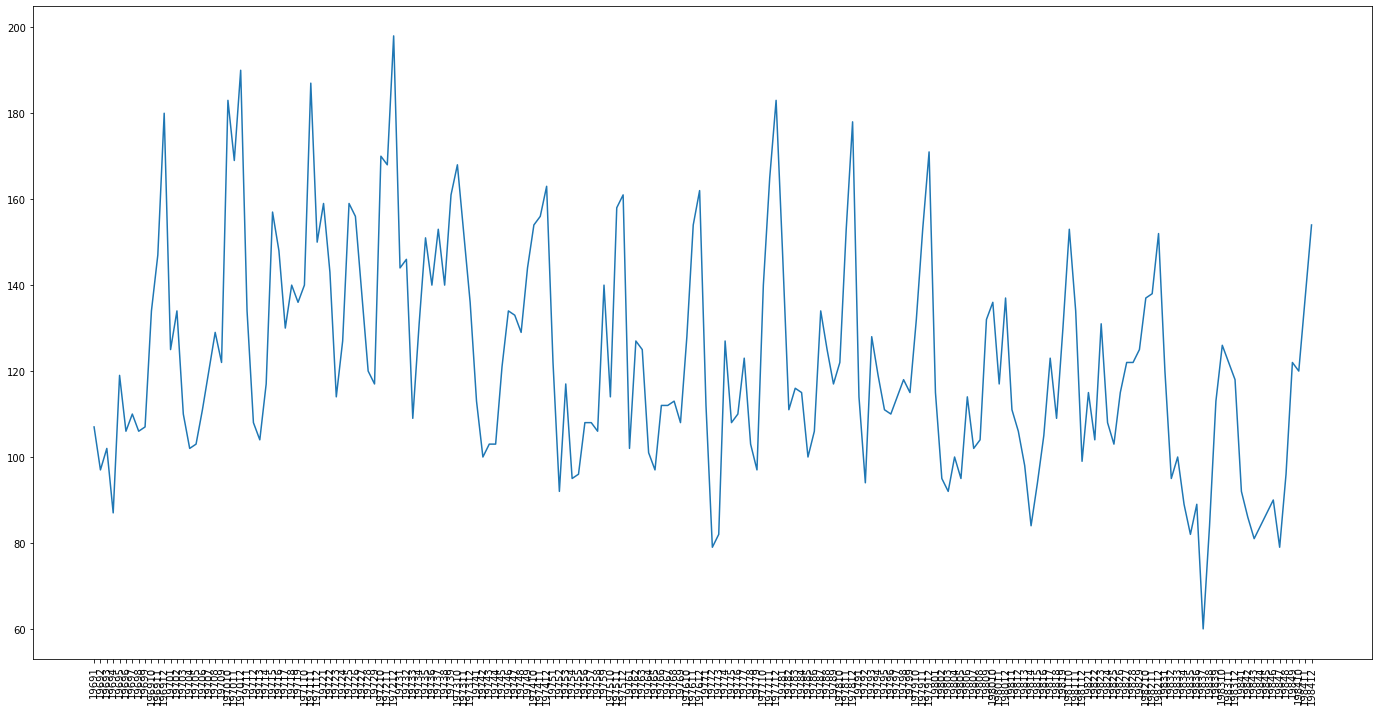

In [40]:
x_labels = (data.year.astype('str') + data.month.astype('str')).values
plt.figure(figsize=(24,12))
plt.plot(data.deaths.values)
plt.xticks(np.arange(192), x_labels, rotation=90)
plt.show()

### Preprocessing



In [41]:
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(data)

In [42]:
response_scaler = MinMaxScaler()
response_scaler.fit(data['deaths'].values.reshape(-1,1))

MinMaxScaler()

### Model training

In [72]:
full_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=1,
    batch_size=64,
    shift=1,
    output_index=0,
    shuffle=True    
)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(12,10)),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(units=1)
])

lstm_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse']
)

history = lstm_model.fit(full_ds,epochs=120, verbose=0)

### Prediction and evaluation

In [73]:
predict_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=1,
    batch_size=127,
    shift=1,
    output_index=0,
    shuffle=False    
)
preds = lstm_model.predict(predict_ds)

In [74]:
orig_preds = response_scaler.inverse_transform(preds)
orig_preds = orig_preds.reshape(-1)

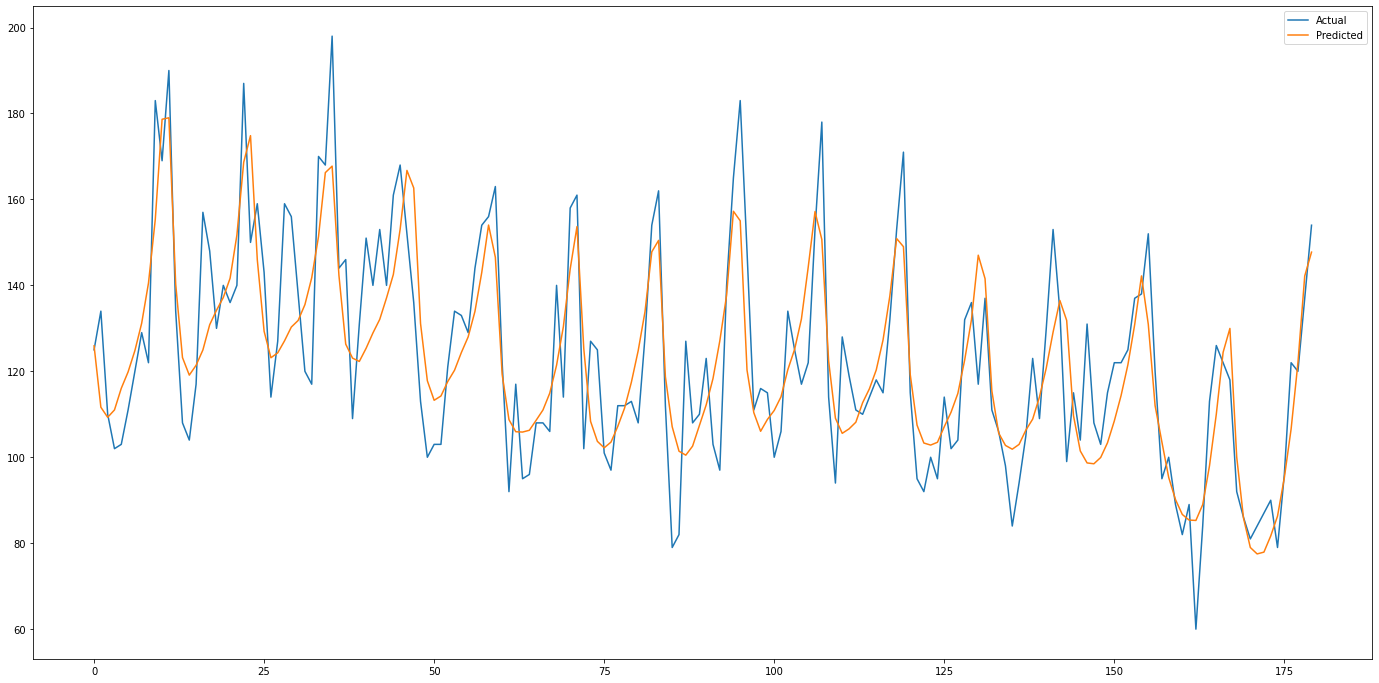

In [75]:
plt.figure(figsize=(24,12))
plt.plot(data['deaths'].values[12:])
plt.plot(orig_preds)
plt.legend(["Actual", "Predicted"])
plt.show()

In [76]:
mean_squared_error(data['deaths'].values[12:], orig_preds)

192.80048196140885

### Residual analysis

In [77]:
residuals = data['deaths'].values[12:] - orig_preds

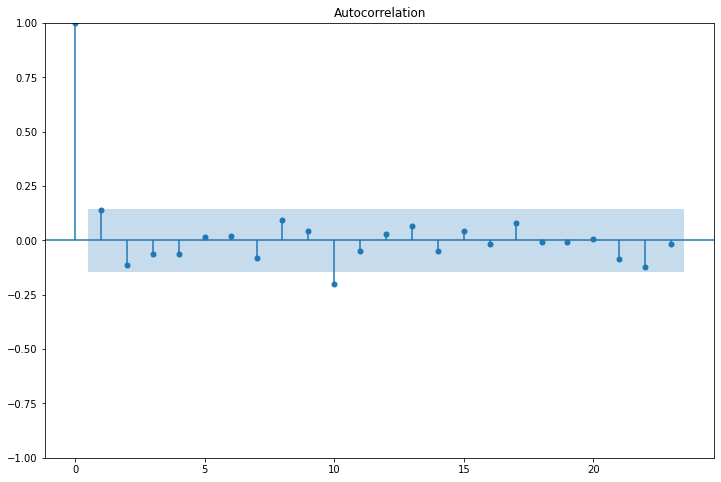

In [78]:
plt.rc("figure", figsize=(12,8))
plot_acf(residuals, bartlett_confint=False)
plt.show()

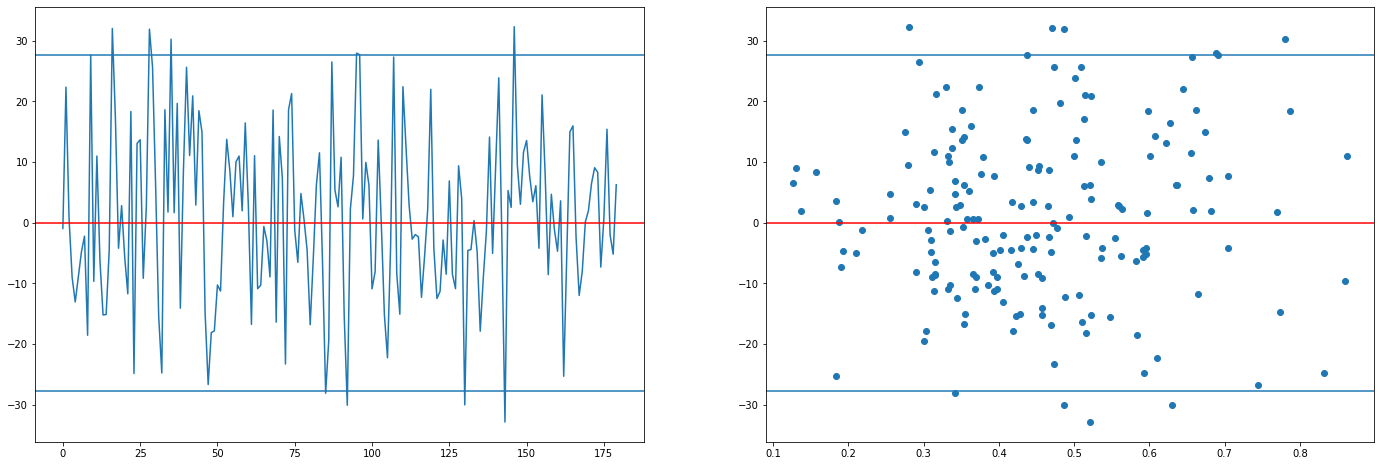

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))

ax1.plot(residuals)
ax1.axhline(0, color='r')
ax1.axhline(2*np.std(residuals))
ax1.axhline(-2*np.std(residuals))

ax2.plot(preds, residuals, 'o')
ax2.axhline(0, color='r')
ax2.axhline(2*np.std(residuals))
ax2.axhline(-2*np.std(residuals))

plt.show()